In [36]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [37]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [38]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [39]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [40]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [41]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [42]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [43]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [79]:
# Find the most recent date in the data set.
with Session(engine) as session:
    date = session.query(func.max(Measurement.date)).one()
    print(date)

('2017-08-23',)


2016-08-23 00:00:00


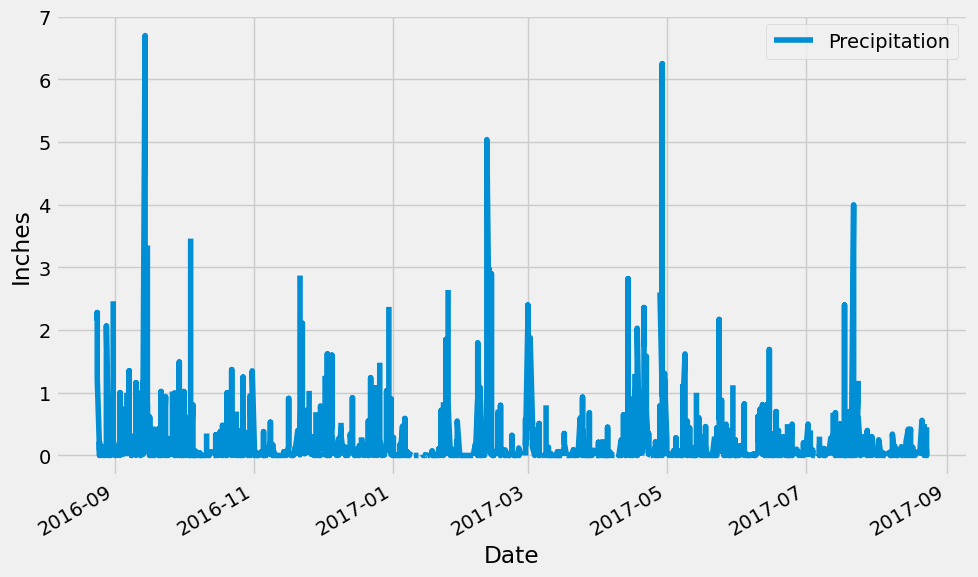

In [105]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
end_date = dt.datetime(2017,8,23)
# Calculate the date one year from the last date in data set.
start_date = end_date - dt.timedelta(days=365)
print(start_date)
# Perform a query to retrieve the data and precipitation scores
with Session(engine) as session:
    results = (
        session.query(Measurement.date, Measurement.prcp)
        .filter(Measurement.date >= start_date)
        .all()
    )

# Save the query results as a Pandas DataFrame. Explicitly set the column names
columns_df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
columns_df['Date'] = pd.to_datetime(columns_df['Date'])
columns_df = columns_df.sort_values('Date')

# Use Pandas Plotting with Matplotlib to plot the data
columns_df.set_index('Date', inplace=True)
columns_df.plot(figsize=(10, 6), legend=True)
plt.ylabel('Inches')
plt.tight_layout()
plt.show()

In [113]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = columns_df['Precipitation'].describe()
summary_stats

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [117]:
# Design a query to calculate the total number of stations in the dataset
with Session(engine) as session:
    total_stations = session.query(func.count(func.distinct(Station.station))).one()
print(total_stations)

(9,)


In [119]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
with Session(engine) as session:
    results = (
        session.query(Measurement.station, func.count(Measurement.station).label('num_observations'))
        .group_by(Measurement.station)
        .order_by(func.count(Measurement.station).desc())
        .all()
    )
    
print(results)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [132]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


with Session(engine) as session:
    most_active_station = (
        session.query(Measurement.station, func.count(Measurement.station).label('num_observations'))
        .group_by(Measurement.station)
        .order_by(func.count(Measurement.station).desc())
        .first()
    )

most_active_station_id = most_active_station.station

with Session(engine) as session:
    temp_stats = (
        session.query(
            func.min(Measurement.tobs),
            func.max(Measurement.tobs),
            func.avg(Measurement.tobs)
        )
        .filter(Measurement.station == most_active_station_id)
        .all()
    )


min_temp, max_temp, avg_temp = temp_stats[0]
print(min_temp, max_temp, avg_temp)


54.0 85.0 71.66378066378067


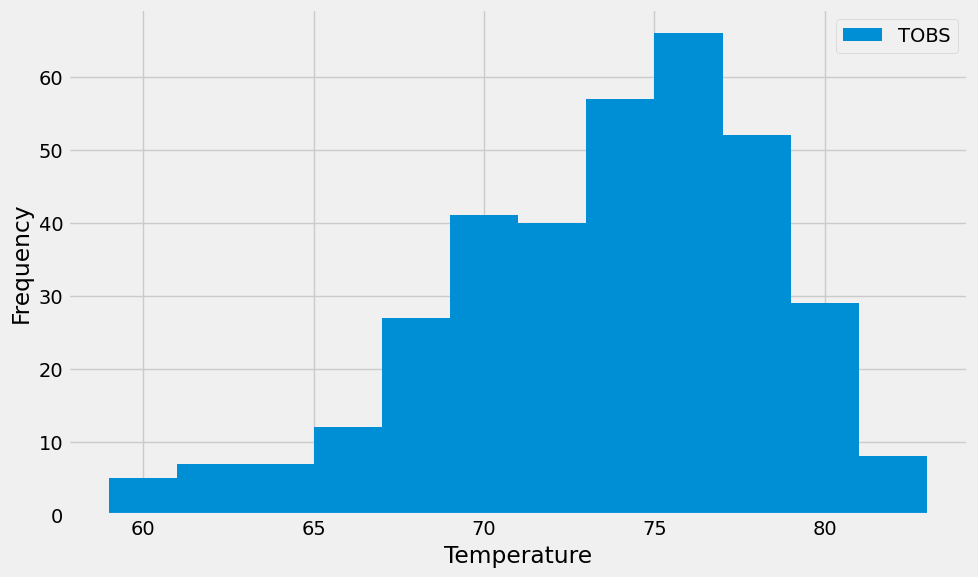

In [144]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
end_date = dt.datetime(2017, 8, 23)
start_date = end_date - dt.timedelta(days=365)

with Session(engine) as session:
    tobs_data = (
        session.query(Measurement.tobs)
        .filter(Measurement.station == most_active_station_id)
        .filter(Measurement.date >= start_date)
        .all()
    )
tobs_df = pd.DataFrame(tobs_data, columns=['TOBS'])

plt.figure(figsize=(10, 6))
plt.hist(tobs_df['TOBS'], bins=12, label='TOBS')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [145]:
# Close Session
session.close()